In [1]:
import pyoti.core as coti
import pyoti.sparse as oti
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern Roman",
    "font.size": 12,
    "font.sans-serif": ["Helvetica"]
})

In [2]:
def fun2(X,r,m,b):
    #INTERSECTION BETWEEN CURVES.
    f = oti.zeros((2,1))
    x = X[0,0].copy()
    y = X[1,0].copy()
    f[0,0] = x**2 + y**2 - r**2 
    f[1,0] = y - ( m * x + b )
    return f

def Jfun2(X,func,verbose,r,m,b):
    #INTERSECTION BETWEEN CURVES.
    J = oti.zeros((2,2))
    x = X[0,0].copy()
    y = X[1,0].copy()
    J[0,0] = 2 * x 
    J[1,0] = - m 
    J[0,1] = 2 * y 
    J[1,1] = 1
    return J

def fun2_curves(x,r,m,b):
    #CURVES.
    y = oti.zeros((x.shape[0],3))
    y[:,0] =  oti.sqrt(r**2 - x**2)
    y[:,1] = -oti.sqrt(r**2 - x**2)
    y[:,2] = m * x + b
    return y


def intersect_pts(r,m,b,alg=oti):
    #CURVES.
        
    #     x[0,0] = (-m*b + oti.sqrt( (m*b)**2 - (m+1)*(b**2-r**2) ) )/( (m+1) )
    #     x[1,0] = (-m*b - oti.sqrt( (m*b)**2 - (m+1)*(b**2-r**2) ) )/( (m+1) )

    x1 = (-b*m + alg.sqrt(-b**2 + m**2*r**2 + r**2))/(m**2 + 1)
    y1 = m * x1 + b
    x2 = (-b*m - alg.sqrt(-b**2 + m**2*r**2 + r**2))/(m**2 + 1)
    y2 = m * x2 + b
        
    return x1,y1,x2,y2

def intersect_pts_dr(r,m,b,alg=oti):
    #CURVES.
        
    #     x[0,0] = (-m*b + oti.sqrt( (m*b)**2 - (m+1)*(b**2-r**2) ) )/( (m+1) )
    #     x[1,0] = (-m*b - oti.sqrt( (m*b)**2 - (m+1)*(b**2-r**2) ) )/( (m+1) )

    x1 = (r)/alg.sqrt(-b**2 + m**2*r**2 + r**2)
    y1 = m * x1
    
    x2 = -(r)/alg.sqrt(-b**2 + m**2*r**2 + r**2)
    y2 = m * x2 
        
    return x1,y1,x2,y2

In [3]:
# utils
def newton_otisis(func, jaco, x, tol, maxiter=50, args=(), verbose=False,eps = 1e-16,stats=False):
    error = 1e30
    n = 0
    nx = x.shape[0]
    dx = oti.zeros( (nx,1), order=x.order)
    
    res_stats = {}
    res_stats['dx']    = []
    res_stats['x']     = []
    res_stats['error'] = []
    res_stats['f']     = []
    res_stats['J']     = []
    
    argv = (func,verbose)+args
    while error > tol:
        res_stats['niter'] = n
        if n==maxiter:
            print("Did not converge. ", maxiter, "iters.")
            break
        # end if 
        if verbose:
            print("Iteration {0}".format(n))
        # end if 
        mJ = -jaco(x,*argv)
        f_eval = func(x,*args)

        
        dx = oti.dot(oti.inv(mJ),f_eval)
        x += dx
        error = oti.norm(dx)/(oti.norm(x)+eps)
        error = (error).get_deriv(0)
        
        res_stats['dx'].append(dx)
        res_stats['x'].append(x)
        res_stats['error'].append(error)
        res_stats['f'].append(f_eval)
        res_stats['J'].append(mJ)
        
        if verbose:
            print("\nf")
            print(f_eval)
            print("\nJ")
            print(-mJ)
            print('\ndx')
            print(dx)
            print("\nx i+1")
            print(x)
            print("Error")
            print("{0:.10f}".format(error))
            print("\n"+100*"=")
        # end if
        n += 1
    # end while
    print("niter: ",n)

    if stats:
        return x, res_stats
    else:
        return x
    # end if 


def j_DF (x, func, *args):
    h = 1e-8
    nx = x.shape[0]
    J = oti.zeros((nx,nx), order=x.order)
    for i in range(nx):
        xh = x.copy()
        xh[i,0]+= h
        dfdxi = (func(xh,*args) - func(x,*args))/h
        for j in range(nx):
            J[j,i] = dfdxi[j,0]
    return J

def j_oti (x, func,verbose, *args):
    nx = x.shape[0]
    active_bases = func(x,*args).get_active_bases()
    if len(active_bases)==0:
        next_base = 1 
    else:
        next_base = max(active_bases) + 1
    # end if 
    
    e_x = oti.zeros((nx,1), order=(x.order+1))
    for i in range(nx):
        e_x[i] = oti.e(next_base + i, order = (x.order+1))  
    # end for 
    J = oti.zeros((nx,nx), order=x.order)
    fun = func(x+e_x, *args) 
    if verbose:
        print('\nf for jacobian')
        print(fun)
    for n in range(nx):
        J_col = fun.extract_deriv(next_base + n)
        
        for j in range(nx):
            J_col = J_col.truncate(next_base + j)
        # end for 
        for m in range(nx):
            J[m,n] = J_col[m,0]
        # end for 
    # end for 
    return J

In [4]:
oti.set_printoptions(float_format='.16e')

In [15]:
order = 2
x0 = oti.array([1,1])
r = oti.number( 4) + oti.e(1, order = order)
m = oti.number( 3) + oti.e(2, order = order)
b = oti.number(-4) # +oti.e(3, order = order)

In [16]:
X,stats = newton_otisis(fun2,j_oti,x0,1e-6, args = (r,m,b), verbose=False, stats=True,maxiter=8)
X2,stats2 = newton_otisis(fun2,j_oti,x0,1e-17, args = (r,m,b), verbose=False, stats=True,maxiter=8)

niter:  6
Did not converge.  8 iters.
niter:  8


In [121]:
X1 = newton_otisis(fun2,Jfun2,x0,1e-15, args = (r,m,b), verbose=False)

niter:  7


In [122]:
stats['error']

[0.7957624157684065,
 0.47013253741746647,
 0.12929987509804525,
 0.008877402339378466,
 4.15370613629057e-05,
 9.093274942239305e-10]

<IPython.core.display.Javascript object>


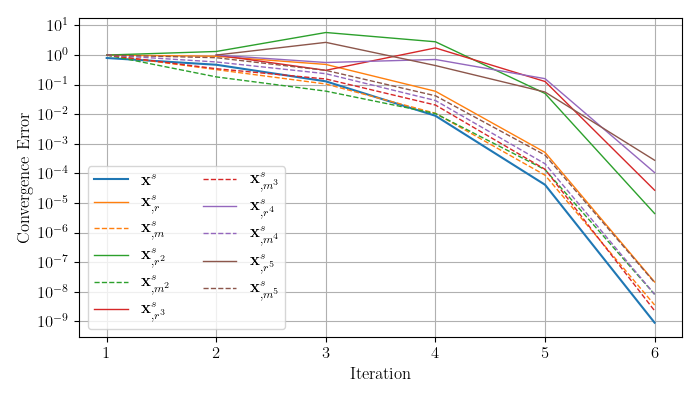

/var/folders/pf/vtrl4y9x2_z5cvft4xm0tb0r0000gp/T/ipykernel_31930/2213419960.py:13: RuntimeWarning: invalid value encountered in double_scalars
  err_b = abs( np.linalg.norm(


In [123]:
plt.figure(figsize=(7,4))

nIter = len(stats['error'])
plt.semilogy(range(1,nIter+1),stats['error'],label=r'$\mathbf{x}^{s}$')

for i in range(1,5+1):
    err_b_plot = []
    err_m_plot = []
    for j in range(len(stats['dx'])):
        dx_i=stats['dx'][j]
        x_i =stats['x'][j]
        err_oti = (oti.norm(dx_i)/oti.norm(x_i))
        err_b = abs( np.linalg.norm( 
                        dx_i.get_deriv([1]*i) 
                        )/np.linalg.norm(
                        x_i.get_deriv([1]*i)
        ))
        err_m = abs( np.linalg.norm( 
                        dx_i.get_deriv([2]*i) 
                        )/np.linalg.norm(
                        x_i.get_deriv([2]*i)
        ))
        #print(err_oti)
        err_b_plot.append(err_b)
        err_m_plot.append(err_m)
        # err_plot.append(err_oti.get_deriv([1]*i))
    # end for
    label_b = r'$\mathbf{{x}}^{{s}}_{{,r{0}}}$'
    label_m = r'$\mathbf{{x}}^{{s}}_{{,m{0}}}$'
    if i == 1:
        label_b = label_b.format("")
        label_m = label_m.format("")
    else:
        label_b = label_b.format("^{0}".format(i))
        label_m = label_m.format("^{0}".format(i))
    # end if      
            
    plt.semilogy(range(1,nIter+1),err_b_plot,'C'+str(i),lw=1,label=label_b)
    plt.semilogy(range(1,nIter+1),err_m_plot,'--C'+str(i),lw=1,label=label_m)
# end for 
ax = plt.gca()

ax.yaxis.set_major_locator(ticker.LogLocator(numticks=17))
plt.legend(ncol=2)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Convergence Error')
plt.tight_layout()
plt.savefig('pdf/err_twoVar_convergence_tol-6.pdf',dpi=300)
plt.show()

<IPython.core.display.Javascript object>


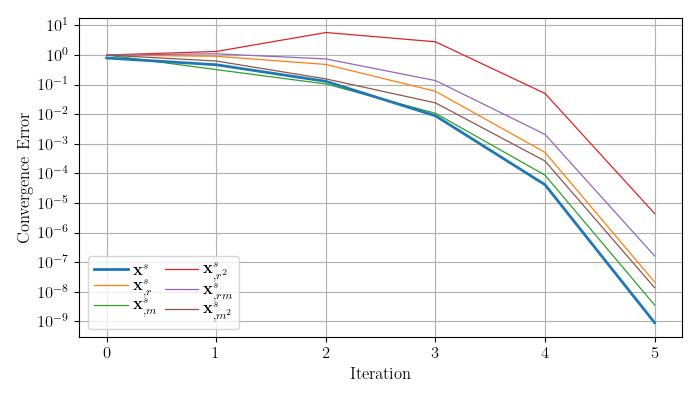

In [45]:
plt.figure(figsize=(7,4))

nIter = len(stats['error'])
nIter2 = len(stats2['error'])
# plt.semilogy(range(nIter2),stats2['error'],color='C0',lw=2,alpha=0.3)
plt.semilogy(range(nIter),stats['error'],color='C0',lw=2,label=r'$\mathbf{x}^{s}$',zorder=5)

# i=0
# for ordi in range(1,order+1):
#     for m_ord in range(ordi+1):
#         r_ord = ordi-m_ord
#         deriv = [1]*r_ord+[2]*m_ord
        
#         err_plot = []
#         for j in range(nIter):
#             dx_i=stats2['dx'][j]
#             x_i =stats2['x'][j]
#             err_b = abs( np.linalg.norm( 
#                 dx_i.get_deriv(deriv) 
#                 )/np.linalg.norm(
#                 x_i.get_deriv(deriv)
#             ))
#             err_plot.append(err_b)
#         plt.semilogy(range(nIter2),err_plot,'C'+str(i),lw=.8,alpha=0.3) 
#         i+=1
        
#     # end for 
# # end for 
i=1
for ordi in range(1,order+1):     
    for m_ord in range(ordi+1):
        r_ord = ordi-m_ord
        deriv = [1]*r_ord+[2]*m_ord
        
        str_key = r'$\mathbf{{x}}^{{s}}_{{,{0}}}$'
        str_deriv = ""
        if r_ord !=0:
            str_deriv += "r"
            if r_ord!=1:
                str_deriv += "^{{{0}}}".format(r_ord)
        if m_ord !=0:
            str_deriv += "m"
            if m_ord!=1:
                str_deriv += "^{{{0}}}".format(m_ord)
        str_key=str_key.format(str_deriv) 
        
        
        err_plot = []
        for j in range(nIter):
            dx_i=stats['dx'][j]
            x_i =stats['x'][j]
            err_b = abs( np.linalg.norm( 
                dx_i.get_deriv(deriv) 
                )/np.linalg.norm(
                x_i.get_deriv(deriv)
            ))
            err_plot.append(err_b)
        plt.semilogy(range(nIter),err_plot,'C'+str(i),lw=.9,label=str_key) 
        i+=1
        
    # end for 
# end for 

ax = plt.gca()
ax.set_xticks(range(nIter))
ax.yaxis.set_major_locator(ticker.LogLocator(numticks=17))
plt.legend(ncol=2,handletextpad=0.3,labelspacing=0.1,columnspacing=0.5)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Convergence Error')
plt.tight_layout()
plt.savefig('pdf/err_twoVar_convergence_allDer_tol-6.pdf',dpi=300)
plt.show()

In [33]:
X[1,0].get_deriv([1])

0.9999999999999999

In [44]:
oti.set_printoptions(float_format='.16f')
X

matso< shape: (2, 1), 
 - Column 0
(0,0) 2.3999999999999999 + 0.3333333333333333 * e([1]) - 0.6400000000000000 * e([2]) - 0.0046296296296296 * e([[1,2]]) - 0.1111111111111111 * e([1,2]) + 0.1440000000000000 * e([[2,2]])
(1,0) 3.1999999999999997 + 0.9999999999999999 * e([1]) + 0.4800000000000000 * e([2]) - 0.0138888888888887 * e([[1,2]]) + 0.0000000000000001 * e([1,2]) - 0.2080000000000000 * e([[2,2]])
>

In [35]:
X1[1,0].get_deriv([1])

1.0

In [34]:
# Compute the analytoc intersection points.
x_int, y_int,x2_int, y2_int = intersect_pts(r,m,b)
print(x_int.real,y_int.real)

2.4000000000000004 3.200000000000001


In [35]:
# Error real part
X_ana = np.array([[x_int.real],[y_int.real]])
np.linalg.norm(X.real-X_ana)/np.linalg.norm(X_ana)

3.5108334685767e-16

In [36]:
for ordi in range(order+1):
    print(ordi)
    if ordi !=0:
        for m_ord in range(ordi+1):
            r_ord = ordi-m_ord
            print(" ",r_ord,m_ord)
            print("deriv:",[1]*r_ord+[2]*m_ord)

0
1
  1 0
deriv: [1]
  0 1
deriv: [2]
2
  2 0
deriv: [1, 1]
  1 1
deriv: [1, 2]
  0 2
deriv: [2, 2]


In [46]:
errs = {}
colors=[]
for ordi in range(order+1):

    
    if ordi !=0:
        for m_ord in range(ordi+1):
            r_ord = ordi-m_ord
            deriv = [1]*r_ord+[2]*m_ord
   
            X_ana = np.array([[x_int.get_deriv(deriv)],[y_int.get_deriv(deriv)]])
            err = np.linalg.norm(X.get_deriv(deriv)-X_ana)/np.linalg.norm(X_ana)
            str_key = r'$\mathbf{{x}}^{{s}}_{{,{0}}}$'
            str_deriv = ""
            if r_ord !=0:
                str_deriv += "r"
                if r_ord!=1:
                    str_deriv += "^{{{0}}}".format(r_ord)
            if m_ord !=0:
                str_deriv += "m"
                if m_ord!=1:
                    str_deriv += "^{{{0}}}".format(m_ord)
            str_key=str_key.format(str_deriv)  
            errs[str_key]=err
            colors.append('C{0}'.format(ordi))
    else:
        colors.append('C{0}'.format(ordi))
        deriv=[0]
        X_ana = np.array([[x_int.get_deriv(deriv)],[y_int.get_deriv(deriv)]])
        err = np.linalg.norm(X.get_deriv(deriv)-X_ana)/np.linalg.norm(X_ana)
        str_key = r'$\mathbf{{x}}^s$'
        errs[str_key]=err
    # end if 
# end for 
    
    
print(errs.keys())
colors

dict_keys(['$\\mathbf{{x}}^s$', '$\\mathbf{x}^{s}_{,r}$', '$\\mathbf{x}^{s}_{,m}$', '$\\mathbf{x}^{s}_{,r^{2}}$', '$\\mathbf{x}^{s}_{,rm}$', '$\\mathbf{x}^{s}_{,m^{2}}$'])


['C0', 'C1', 'C1', 'C2', 'C2', 'C2']

<IPython.core.display.Javascript object>


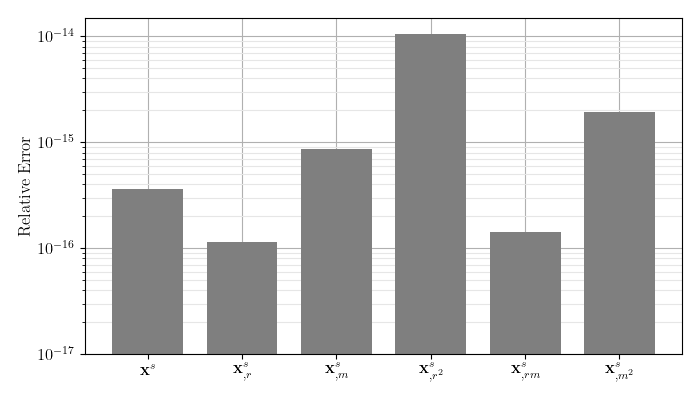

In [48]:

plt.figure(figsize=(7,4))

x = range(len(errs.keys()))

plt.bar(x,errs.values(),
#         color=colors,
        color='C7',
        width=0.75,
        bottom=1e-17,
        tick_label=list(errs.keys())
       )
ax = plt.gca()
# ax.set_xticks(x)
# ax.set_xticklabels(fontsize=10)

ax.set_yscale('log')
ax.set_axisbelow(True)

plt.xticks(fontsize=12,rotation=0,ha='center',va='top')
plt.grid(which='minor',color=(0.9,0.9,0.9))
plt.grid()

plt.ylabel('Relative Error')
plt.tight_layout()

plt.savefig('pdf/err_allderivs.pdf')
plt.show()

In [74]:
X.rom_eval([1,2],[2,1])

matso< shape: (2, 1), 
 - Column 0
(0,0) 2.3299259259259260
(1,0) 5.4164444444444442
>

In [73]:
intersect_pts(6,4,-4)

(2.3772418371451414,
 5.5089673485805655,
 -0.4948888959686708,
 -5.979555583874683)

In [75]:
np.linalg.norm([2.3299259259259260-2.3772418371451414,5.4164444444444442-5.5089673485805655])/np.linalg.norm([2.3772418371451414, 5.5089673485805655])

0.01731993331739679

In [36]:
list(errs.keys())

['\\mathbf{x}^s',
 '\\mathbf{x}^s_{,r}',
 '\\mathbf{x}^s_{,m}',
 '\\mathbf{x}^s_{,r^2}',
 '\\mathbf{x}^s_{,m^2}',
 '\\mathbf{x}^s_{,r^3}',
 '\\mathbf{x}^s_{,m^3}',
 '\\mathbf{x}^s_{,r^4}',
 '\\mathbf{x}^s_{,m^4}',
 '\\mathbf{x}^s_{,r^5}',
 '\\mathbf{x}^s_{,m^5}',
 '\\mathbf{x}^s_{,r^6}',
 '\\mathbf{x}^s_{,m^6}']

<IPython.core.display.Javascript object>


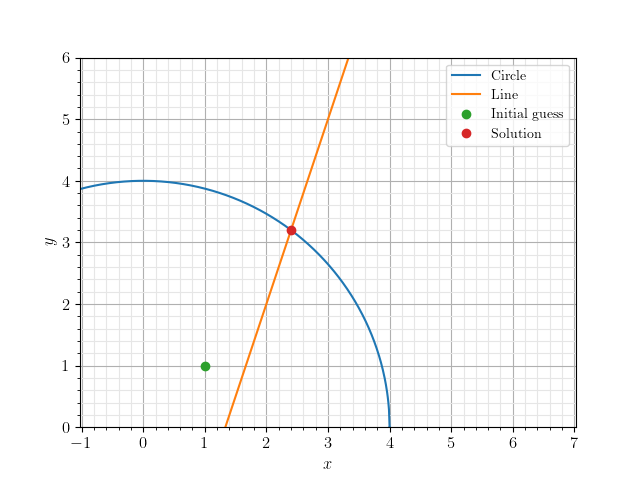

In [163]:
# Plot the system
plt.figure()

d = r.real+2
x_plot_r = np.arange(-d,d,0.01)
x_plot   = oti.array(x_plot_r)

Y = fun2_curves(x_plot,r.real,m.real,b.real)
y_circ_up= Y[:,0]
y_circ_dn= Y[:,1]
y_line   = Y[:,2]

plt.plot(x_plot_r,y_circ_up.real,c='C0',label='Circle')
plt.plot(x_plot_r,y_circ_dn.real,c='C0')

plt.plot(x_plot_r,y_line.real   ,c='C1',label='Line')




# plt.plot(x_int.real,y_int.real,'.', c='C2', label='Intersection')

plt.plot(x0[0].real ,x0[1].real ,'o', c='C2', label='Initial guess')
plt.plot(X[0].real ,X[1].real ,'o', c='C3', label='Solution')


plt.axis('equal')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
plt.legend(fontsize=10)

plt.axis([0,d,0,d])
plt.grid()
plt.grid(which='minor', color=(0.9,0.9,0.9))
plt.xlabel('$x$')
plt.ylabel('$y$')


plt.savefig("pdf/line-circ-intersect.pdf",dpi=150)
plt.show()

In [164]:
Δr = 0.0
Δm = -2.0
Δb = 0.0
m

3.0000e+00 + 1.0000e+00 * e([2])

<IPython.core.display.Javascript object>


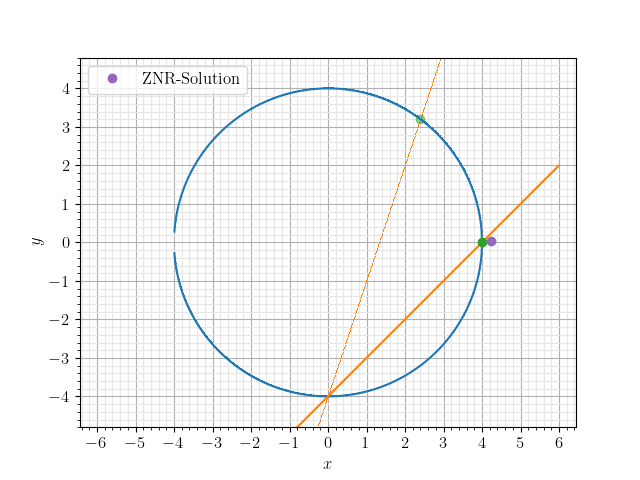

In [165]:
rnew = r.rom_eval([1,2,3],[Δr,Δm,Δb])
mnew = m.rom_eval([1,2,3],[Δr,Δm,Δb])
bnew = b.rom_eval([1,2,3],[Δr,Δm,Δb])
Xnew = X.rom_eval([1,2,3],[Δr,Δm,Δb])

# Plot the system
plt.figure()

d = r.real+2
x_plot_r = np.arange(-d,d,0.01)
x_plot   = oti.array(x_plot_r)

Y = fun2_curves(x_plot,r.real,m.real,b.real)
y_circ_up= Y[:,0]
y_circ_dn= Y[:,1]
y_line   = Y[:,2]

plt.plot(x_plot_r,y_circ_up.real,',',c='C0',ms=5)
plt.plot(x_plot_r,y_circ_dn.real,',',c='C0',ms=5)

plt.plot(x_plot_r,y_line.real  ,',' ,c='C1')

plt.plot(x_int.real,y_int.real , 'o' ,c='C2',alpha=0.5)

Y = fun2_curves(x_plot,rnew.real,mnew.real,bnew.real)
y_circ_up= Y[:,0]
y_circ_dn= Y[:,1]
y_line   = Y[:,2]

plt.plot(x_plot_r,y_circ_up.real,'-',c='C0')
plt.plot(x_plot_r,y_circ_dn.real,'-',c='C0')

plt.plot(x_plot_r,y_line.real   ,'-',c='C1')

x_intnew, y_intnew,x2_intnew, y2_intnew = intersect_pts(rnew,mnew,bnew)
plt.plot(x_intnew.real,y_intnew.real , 'o' ,c='C2')
# plt.plot(x2_intnew.real,y2_intnew.real , 'o' ,c='C3')

plt.plot(Xnew[0].real ,Xnew[1].real ,'o', c='C4', label='ZNR-Solution')


plt.axis('equal')
plt.xlabel('$x$')
plt.ylabel('$y$')
ax = plt.gca()

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))

eps = r.real*1.2
plt.axis([-eps,eps,-eps,eps])
plt.grid()
plt.legend()
plt.grid(which='minor', color=(0.9,0.9,0.9))

plt.savefig("pdf/line-circ-intersect-newsol.pdf",dpi=150)
plt.show()

<IPython.core.display.Javascript object>


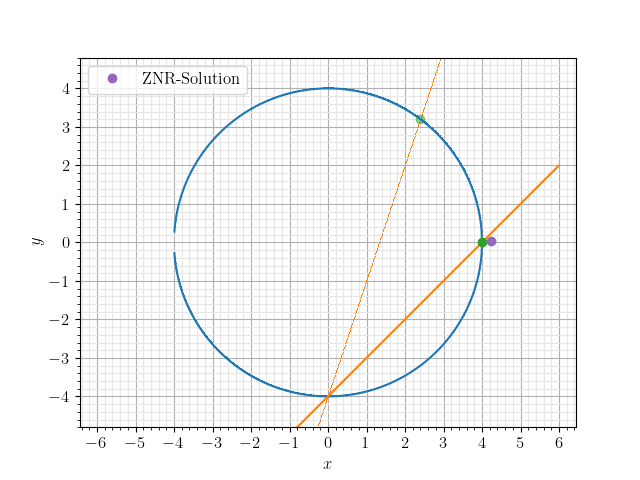

In [166]:
dr = np.linspace((-r).real,(r).real,200)
dm = np.linspace((-m).real,(m).real,200)

dR,dM = np.meshgrid(dr,dm)

x_sol = X[0,0]
y_sol = X[1,0]

ordEstim = 20
ordDelta = 1

Xeval = x_sol.truncate_order(ordEstim).rom_eval_object([1,2],[dR,dM])
Yeval = y_sol.truncate_order(ordEstim).rom_eval_object([1,2],[dR,dM])

# Plot the system
plt.figure()

d = r.real+2
x_plot_r = np.arange(-d,d,0.01)
x_plot   = oti.array(x_plot_r)

Y = fun2_curves(x_plot,r.real,m.real,b.real)
y_circ_up= Y[:,0]
y_circ_dn= Y[:,1]
y_line   = Y[:,2]

plt.plot(x_plot_r,y_circ_up.real,',',c='C0',ms=5)
plt.plot(x_plot_r,y_circ_dn.real,',',c='C0',ms=5)

plt.plot(x_plot_r,y_line.real  ,',' ,c='C1')

plt.plot(x_int.real,y_int.real , 'o' ,c='C2',alpha=0.5)

Y = fun2_curves(x_plot,rnew.real,mnew.real,bnew.real)
y_circ_up= Y[:,0]
y_circ_dn= Y[:,1]
y_line   = Y[:,2]

plt.plot(x_plot_r,y_circ_up.real,'-',c='C0')
plt.plot(x_plot_r,y_circ_dn.real,'-',c='C0')

plt.plot(x_plot_r,y_line.real   ,'-',c='C1')

x_intnew, y_intnew,x2_intnew, y2_intnew = intersect_pts(rnew,mnew,bnew)
plt.plot(x_intnew.real,y_intnew.real , 'o' ,c='C2')
# plt.plot(x2_intnew.real,y2_intnew.real , 'o' ,c='C3')

plt.plot(Xnew[0].real ,Xnew[1].real ,'o', c='C4', label='ZNR-Solution')


plt.axis('equal')
plt.xlabel('$x$')
plt.ylabel('$y$')
ax = plt.gca()

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))

eps = r.real*1.2
plt.axis([-eps,eps,-eps,eps])
plt.grid()
plt.legend()
plt.grid(which='minor', color=(0.9,0.9,0.9))

plt.savefig("pdf/line-circ-intersect-newsol.pdf",dpi=150)
plt.show()

<IPython.core.display.Javascript object>


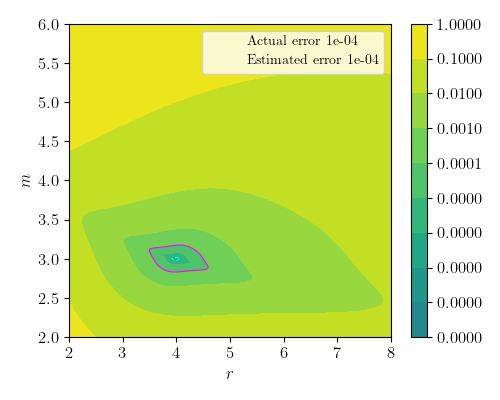

In [57]:
dr = np.linspace((-r).real,(r).real,200)
dm = np.linspace((-m).real,(m).real,200)

dr = np.linspace((-2.0).real,(4.0).real,200)
dm = np.linspace((-1).real,(3).real,200)

dR,dM = np.meshgrid(dr,dm)
x_sol = X[0,0]
y_sol = X[1,0]

ordEstim = 2
ordDelta = 1

Xeval = x_sol.truncate_order(ordEstim).rom_eval_object([1,2],[dR,dM])
Yeval = y_sol.truncate_order(ordEstim).rom_eval_object([1,2],[dR,dM])

Xexact,Yexact, _, _ = intersect_pts( r.real+dR, m.real+dM, b.real ,alg=np)

err = np.sqrt((Xeval-Xexact)**2 + (Yeval-Yexact)**2)+1e-16
err = err / (np.sqrt(Xexact**2+Yexact**2)+1e-16)

errEstX = x_sol.truncate_order(ordEstim)-x_sol.truncate_order(ordEstim-ordDelta)
errEstY = y_sol.truncate_order(ordEstim)-y_sol.truncate_order(ordEstim-ordDelta)

errEstX = errEstX.rom_eval_object([1,2],[dR,dM])
errEstY = errEstY.rom_eval_object([1,2],[dR,dM])
errEst = np.sqrt(errEstX**2 + errEstY**2)

# err = np.ma.masked_where(err <= 1e-13, err)


fig = plt.figure(figsize=(5,4))
X_PLOT = 100*dR/r.real
Y_PLOT = 100*dM/m.real

X_PLOT = dR+r.real
Y_PLOT = dM+m.real
cs = plt.contourf(X_PLOT,Y_PLOT , err, 
                  locator=ticker.LogLocator(), 
                  vmin=1e-16,
)

errPlot = 1e-4
cs_act = plt.contour(X_PLOT,Y_PLOT , err, 
                     linewidths = 0.8,
                     levels=[errPlot],
                     colors='magenta'
)
cs_est = plt.contour(X_PLOT,Y_PLOT , errEst, 
            linestyles = 'dashed',
            linewidths = 0.8,
            levels=[errPlot],
            colors='cyan',
)

plt.xlabel('$r$')
plt.ylabel('$m$')
fig.colorbar(cs)
plt.tight_layout()

cs_act.collections[0].set_label('Actual error {0:.0e}'.format(errPlot))
cs_est.collections[0].set_label('Estimated error {0:.0e}'.format(errPlot))
plt.legend(fontsize=10)
# l_act = plt.clabel(cs_act, inline=True,inline_spacing=20)
# l_act[0].set_text("Actual")
# l_act[0].set_size(12)

# l_est = plt.clabel(cs_est, inline=True,inline_spacing=20)
# l_est[0].set_text("Estimated")
# l_est[0].set_size(12)
# plt.grid()
plt.xlabel('$r$')
plt.ylabel('$m$')
plt.tight_layout()
plt.savefig('error_romn{0:d}_ordDiff{1:d}_mr_em{1:d}_w_est.pdf'.format(int(ordEstim),int(ordDelta),int(abs(np.log10(errPlot)))),dpi=15)
plt.show()

In [58]:
errPlot

0.0001

<IPython.core.display.Javascript object>


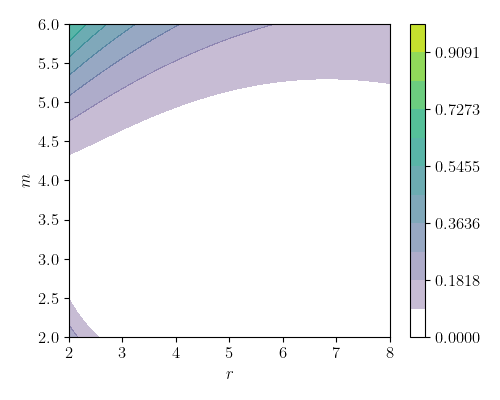

In [59]:
fig = plt.figure(figsize=(5,4))

tol_err = errPlot
tol_err = -np.log10(tol_err)

alpha=err
# alpha = -np.log10(err)
# alpha -= tol_err
# alpha[alpha<0]=0
# alpha[np.isnan(alpha)]=0
# alpha /= np.max(alpha) 
# alpha = alpha.flatten()

color = np.linspace(0,1,int(16-tol_err))
cmap = plt.cm.get_cmap('viridis')
colors = cmap(color)
colors[:,3]=color**.5

cs = plt.contourf(X_PLOT,Y_PLOT,alpha,
                  #locator=ticker.LogLocator(), 
                  #vmin=1e-16,
                  levels=color,
                  colors=colors,
)

fig.colorbar(cs)

plt.xlabel('$r$')
plt.ylabel('$m$')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


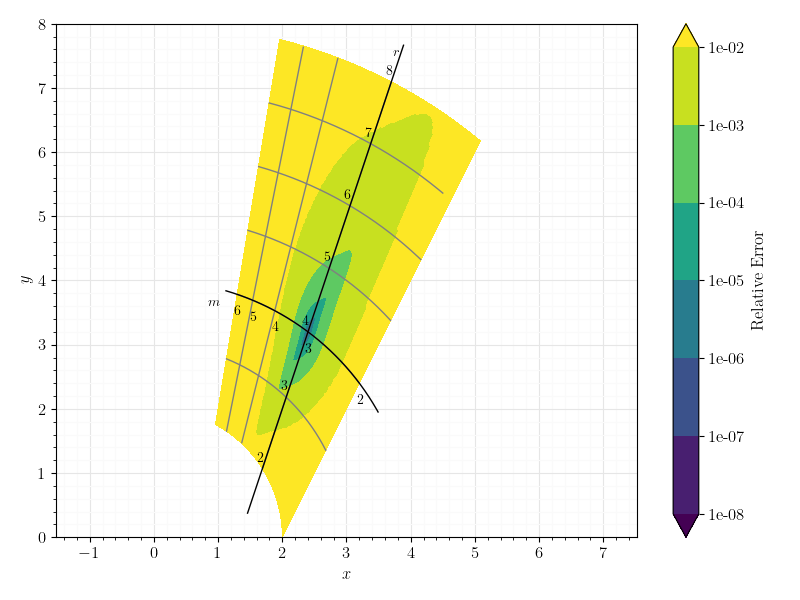

In [72]:
fig=plt.figure(figsize=(8,6))

err_plt = err.copy()
err_plt[err_plt>1e-2]=2e-2
colors[:,3]=color[::-1]**0.1
cs = plt.contourf(Xexact,Yexact,err_plt,
                  locator=ticker.LogLocator(), 
#                   levels=[10**i for i in range(-16,-3)],
#                   levels = [10**i for i in range(-16,-16+len(colors)+1)],
                  cmap='viridis',extend='both',vmax=1e-2)

# cs_act = plt.contour(Xeval, Yeval, err, 
#                      linewidths = 0.8,
#                      levels=[errPlot],
#                      colors='magenta'
# )



d = r.real+2

delta = 0.05

# for i in range(0,Xeval.shape[0],10):
#     for j in range(0,Xeval.shape[1],10):
        
#         if alpha[i,j]!= 0.0:
#             rn = r.real + dR[i,j]
#             mn = m.real + dM[i,j]
#             x_plot_r = np.linspace(Xeval[i,j]-delta,Xeval[i,j]+delta,50)
#             x_plot   = oti.array(x_plot_r)
            
#             Y = fun2_curves(x_plot,rn,mn,b.real)
#             y_circ_up= Y[:,0]
#             y_circ_dn= Y[:,1]
#             y_line   = Y[:,2]



#             plt.plot(x_plot_r,y_circ_up.real,'-',c='k',lw=1,ms=5,alpha=alpha[i,j]**.5)
#             plt.plot(x_plot_r,y_circ_dn.real,'-',c='k',lw=1,ms=5,alpha=alpha[i,j]**.5)

#             plt.plot(x_plot_r,y_line.real  ,'-' ,c='k',lw=1,alpha=alpha[i,j]**.5)

m_plot = np.array([2,3,4,5,6])
m_min = min(m_plot)
m_max = max(m_plot)
r_plot = np.array([2,2.5,3,3.5,4,4.5,5.0,5.5,6.0,6.5])
r_plot = np.array([2,3,4,5.0,6.0,7,8])
r_min =  min(r_plot)
r_max =  max(r_plot)
gr = 0.5
for m_pl in m_plot:
    if m_pl != m_min and m_pl != m_max:
        x_plot_r = np.linspace(0.9,4.5,1000)
        x_plot   = oti.array(x_plot_r)

        Y = fun2_curves(x_plot,r.real,m_pl,b.real)
        y_circ_up= Y[:,0]
        y_line   = Y[:,2]

        r_check = np.sqrt(x_plot.real**2+y_line.real**2)
    #     print(r_check)
        plot_i = np.logical_and(np.logical_and( r_check>=r_min , r_check<=r_max ),y_line.real>0).flatten()
    #     plt.plot(x_plot_r,y_circ_up.real,'-', c='k', lw=1, ms=5)
    #     plt.plot(x_plot_r,y_circ_dn.real,'-', c='k', lw=1, ms=5)

        plt.plot(x_plot.real[plot_i],y_line.real[plot_i]  ,'-' , c=(gr,gr,gr), lw=1)
    
for r_pl in r_plot:
    if r_pl != r_min and r_pl != r_max:
        x_plot_r = np.linspace(0.9,4.5,1000)
        x_plot   = oti.array(x_plot_r)

        Y = fun2_curves(x_plot,r_pl,m.real,b.real)
        y_circ_up= Y[:,0]

        m_check = (y_circ_up.real-b.real)/x_plot.real
        plot_i = np.logical_and( m_check>=m_min , m_check<=m_max ).flatten()
    #     plt.plot(x_plot_r,y_circ_up.real,'-', c='k', lw=1, ms=5)
    #     plt.plot(x_plot_r,y_circ_dn.real,'-', c='k', lw=1, ms=5)

        plt.plot(x_plot.real[plot_i],y_circ_up.real[plot_i]  ,'-' , c=(gr,gr,gr), lw=1)


for r_pl in r_plot:
    
    x1,y1,x2,y2=intersect_pts(r_pl,m.real,b.real,alg=np)
    
    plt.annotate('{:.0f}'.format(r_pl),
                 xy=(x1,y1),
                 xytext=(1,5),ha='right',
                 textcoords='offset points',fontsize=10)
for m_pl in m_plot:
    
    x1,y1,x2,y2=intersect_pts(r.real,m_pl,b.real,alg=np)
    
    plt.annotate('{:.0f}'.format(m_pl),
                 xy=(x1,y1),
                 xytext=(-2,-8),ha='left',va='top',
                 textcoords='offset points',fontsize=10)
    
    
x1,y1,x2,y2=intersect_pts(r_max+.3,m.real,b.real,alg=np)
plt.annotate('$r$',
             xy=(x1,y1),
             xytext=(1,5),ha='right',
             textcoords='offset points',fontsize=10)

x1,y1,x2,y2=intersect_pts(r.real,m_max+1.5,b.real,alg=np)
plt.annotate('$m$',
             xy=(x1,y1),
             xytext=(-5,-5),ha='center',va='top',
             textcoords='offset points',fontsize=10)

rn = r.real
mn = m.real
x_plot_r = np.linspace(0.7,5,500)
x_plot   = oti.array(x_plot_r)

Y = fun2_curves(x_plot,rn,mn,b.real)
y_circ_up= Y[:,0]
y_circ_dn= Y[:,1]
y_line   = Y[:,2]

m_check = (y_circ_up.real-b.real)/x_plot.real
r_check = np.sqrt(x_plot.real**2+y_line.real**2)

plot_i=np.logical_and(np.logical_and( r_check>=r_min-0.5 , r_check<=r_max+0.6 ),y_line.real>0).flatten()
plot_m = np.logical_and( m_check>=m_min-.3 , m_check<=m_max+1 ).flatten()

plt.plot(x_plot_r[plot_m],y_circ_up.real[plot_m],'-',c='k',lw=1,ms=5)

plt.plot(x_plot_r[plot_i],y_line.real[plot_i]  ,'-' ,c='k',lw=1)

plt.axis('equal')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
# plt.legend(fontsize=10)

plt.axis([0,r.real*1.5,0,r.real*2])
plt.grid(color=(0.9,0.9,0.9))
plt.grid(which='minor', color=(0.98,0.98,0.98))
clBar = fig.colorbar(cs,format=ticker.LogFormatter())
ax.set_axisbelow(True)
tks = clBar.get_ticks()

# errTick = [r"$10^{{{0:d}}}$".format(i) for i in range(-16,-16+len(colors)+1,int((16-len(colors))/len(tks)))]
# clBar.set_ticklabels(errTick,)

# plt.title("ROM around $r={0:d}$ and $m={1:d}$ with {2:d}'th order derivatives".format(int(r.real),int(m.real),ordEstim))
plt.xlabel('$x$')
plt.ylabel('$y$')
clBar.ax.set_ylabel('Relative Error')
cs_act.collections[0].set_label('Actual error {0:.0e}'.format(errPlot))
cs_est.collections[0].set_label('Estimated error {0:.0e}'.format(errPlot))
# plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig('errorCartesian_romn{0:d}_ordDiff{1:d}_mr_em{1:d}_w_est.pdf'.format(int(ordEstim),int(ordDelta),int(abs(np.log10(errPlot)))),dpi=15)
plt.show()

In [146]:
[10**i for i in range(-16,-16+len(colors)+1)]

[1e-16,
 1e-15,
 1e-14,
 1e-13,
 1e-12,
 1e-11,
 1e-10,
 1e-09,
 1e-08,
 1e-07,
 1e-06,
 1e-05,
 0.0001]

In [36]:
len(tks)

6

In [33]:
[r"$10^{{{0:d}}}$".format(i) for i in range(-16,-16+len(colors)+1)]

['$10^{-16}$',
 '$10^{-15}$',
 '$10^{-14}$',
 '$10^{-13}$',
 '$10^{-12}$',
 '$10^{-11}$',
 '$10^{-10}$',
 '$10^{-9}$',
 '$10^{-8}$',
 '$10^{-7}$',
 '$10^{-6}$']

In [14]:
help(clBar.set_ticklabels)

Help on method set_ticklabels in module matplotlib.colorbar:

set_ticklabels(ticklabels, update_ticks=True) method of matplotlib.colorbar.Colorbar instance
    Set tick labels.
    
    Tick labels are updated immediately unless *update_ticks* is *False*,
    in which case one should call `.update_ticks` explicitly.



In [35]:
tol_err

6.0

In [164]:
[10**i for i in range(-16,-3)]


[1e-16,
 1e-15,
 1e-14,
 1e-13,
 1e-12,
 1e-11,
 1e-10,
 1e-09,
 1e-08,
 1e-07,
 1e-06,
 1e-05,
 0.0001]

In [101]:
# cmap(255)
# colors
np.max(alpha) 

1.0

In [30]:
r_plot = oti.array( np.linspace(1.5,r.real+20,500) )

dr = np.linspace((-r).real,(r).real,200)
dm = np.linspace((-m).real,(m).real,200)

dRnp,dMnp = np.meshgrid(dr,dm)
dR = oti.array(dRnp)
dM = oti.array(dMnp)


# x_intanalyt, y_intanalyt = intersect_eval(r_plot,m.real,b.real)
x_intanalyt, y_intanalyt, x2_intanalyt, y2_intanalyt = intersect_pts( dR, dM, b )

# plt.figure(figsize=(5,4))

# plt.title('$x_i(r)$')
# plt.plot(r_plot.real,x_intanalyt.real,'-',c='C0',lw=2)

# # Get the TSE behavior.
# x_oti = X[0,0]
# xnew_eval = np.zeros_like(r_plot.real)
# ordi = 30
# for i in range(r_plot.size):
#     x_oti_eval = x_oti.truncate([[1,ordi+1]])
# #     print( x_oti_eval.rom_eval([1,2,3],[(r_plot[i,0]-r).real,0,0]).real)
#     xnew_eval[i] = x_oti_eval.rom_eval([1,2,3],[(r_plot[i,0]-r).real,0,0]).real

# plt.plot(r_plot.real,xnew_eval,'-',c='C1',ms=5,label='ROM Order '+str(ordi))

# plt.plot(r.real,X[0,0].real,'o',c='C2',ms=10,label='Evaluation point r={0:.1f}'.format(r.real))

# # plt.axis('equal')
# plt.xlabel('b')
# plt.ylabel('$x_i$')
# ax = plt.gca()

# # ax.xaxis.set_major_locator(MultipleLocator(1))
# # ax.yaxis.set_major_locator(MultipleLocator(1))
# ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))

# plt.grid(which='minor', color=(0.9,0.9,0.9))

# plt.axis([None,None,1.1,10])
# plt.grid()
# plt.legend(fontsize=10)
# plt.tight_layout()

# plt.show()



<IPython.core.display.Javascript object>


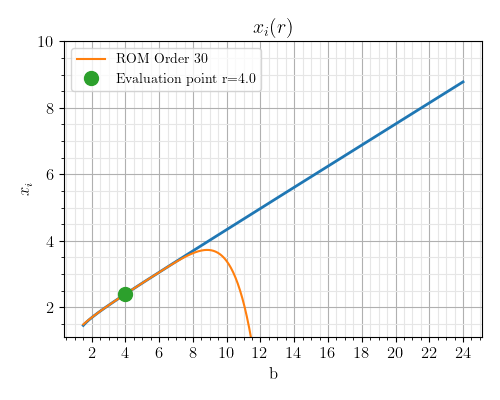

In [24]:
r_plot = oti.array( np.linspace(1.5,r.real+20,500) )
# x_intanalyt, y_intanalyt = intersect_eval(r_plot,m.real,b.real)
x_intanalyt, y_intanalyt, x2_intanalyt, y2_intanalyt = intersect_pts( r_plot, m, b)


plt.figure(figsize=(5,4))

plt.title('$x_i(r)$')
plt.plot(r_plot.real,x_intanalyt.real,'-',c='C0',lw=2)

# Get the TSE behavior.
x_oti = X[0,0]
xnew_eval = np.zeros_like(r_plot.real)
ordi = 30
for i in range(r_plot.size):
    x_oti_eval = x_oti.truncate([[1,ordi+1]])
#     print( x_oti_eval.rom_eval([1,2,3],[(r_plot[i,0]-r).real,0,0]).real)
    xnew_eval[i] = x_oti_eval.rom_eval([1,2,3],[(r_plot[i,0]-r).real,0,0]).real

plt.plot(r_plot.real,xnew_eval,'-',c='C1',ms=5,label='ROM Order '+str(ordi))

plt.plot(r.real,X[0,0].real,'o',c='C2',ms=10,label='Evaluation point r={0:.1f}'.format(r.real))

# plt.axis('equal')
plt.xlabel('b')
plt.ylabel('$x_i$')
ax = plt.gca()

# ax.xaxis.set_major_locator(MultipleLocator(1))
# ax.yaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))

plt.grid(which='minor', color=(0.9,0.9,0.9))

plt.axis([None,None,1.1,10])
plt.grid()
plt.legend(fontsize=10)
plt.tight_layout()

plt.show()

<IPython.core.display.Javascript object>


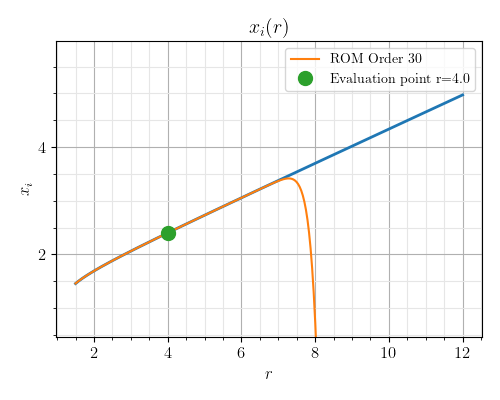

In [29]:

r_plot = np.linspace(1.5,r.real+8,500)
x_intanalyt, y_intanalyt = intersect_eval(r_plot,m.real,b.real)


plt.figure(figsize=(5,4))

plt.title('$x_i(r)$')
plt.plot(r_plot,x_intanalyt,'-',c='C0',lw=2)

# Get the TSE behavior.
x_oti = X[0,0]
xnew_eval = np.zeros_like(r_plot)
ordi = 30
for i in range(r_plot.size):
    x_oti_eval = x_oti.truncate([[1,ordi+1]])
    xnew_eval[i] = x_oti_eval.rom_eval([1,2,3],[r_plot[i]-r.real,0,0]).real

plt.plot(r_plot,xnew_eval,'-',c='C1',ms=5,label='ROM Order '+str(ordi))

plt.plot(r.real,X[0,0].real,'o',c='C2',ms=10,label='Evaluation point r={0:.1f}'.format(r.real))

# plt.axis('equal')
plt.xlabel('$r$')
plt.ylabel('$x_i$')
ax = plt.gca()

# ax.xaxis.set_major_locator(MultipleLocator(1))
# ax.yaxis.set_major_locator(MultipleLocator(1))

plt.axis([
    None,None,
    min(x_intanalyt[~np.isnan(x_intanalyt)])-1,
    max(x_intanalyt[~np.isnan(x_intanalyt)])+1])
plt.grid()
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
plt.grid(which='minor', color=(0.9,0.9,0.9))
plt.legend(fontsize=10)
plt.tight_layout()

plt.show()


<IPython.core.display.Javascript object>


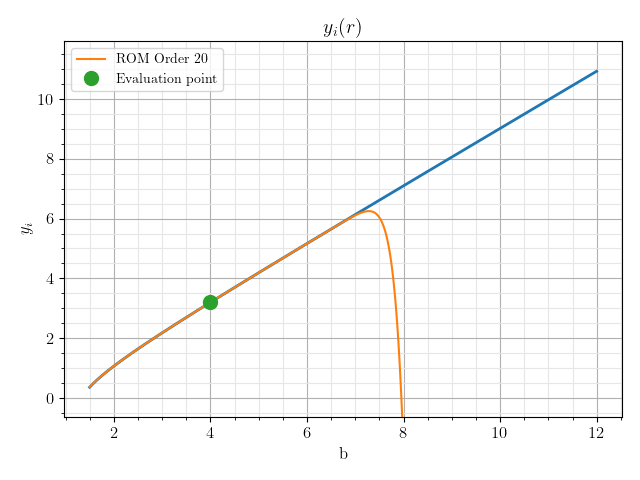

In [27]:
plt.figure()

plt.title('$y_i(r)$')
plt.plot(r_plot,y_intanalyt,'-',c='C0',lw=2)

# Get the TSE behavior.
y_oti = X[1,0]
ynew_eval = np.zeros_like(r_plot)
ordi = 20
for i in range(r_plot.size):
    y_oti_eval = y_oti.truncate([[1,ordi+1]])
    ynew_eval[i] = y_oti_eval.rom_eval([1,2,3],[r_plot[i]-r.real,0,0]).real

plt.plot(r_plot,ynew_eval,'-',c='C1',ms=5,label='ROM Order '+str(ordi))

plt.plot(r.real,X[1,0].real,'o',c='C2',ms=10,label='Evaluation point')

# plt.axis('equal')
plt.xlabel('b')
plt.ylabel('$y_i$')
ax = plt.gca()

# ax.xaxis.set_major_locator(MultipleLocator(1))
# ax.yaxis.set_major_locator(MultipleLocator(1))

plt.axis([
    None,None,
    min(y_intanalyt[~np.isnan(y_intanalyt)])-1,
    max(y_intanalyt[~np.isnan(y_intanalyt)])+1])


ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
plt.grid()
plt.grid(which='minor', color=(0.9,0.9,0.9))
plt.legend(fontsize=10)
plt.tight_layout()

plt.show()

<IPython.core.display.Javascript object>


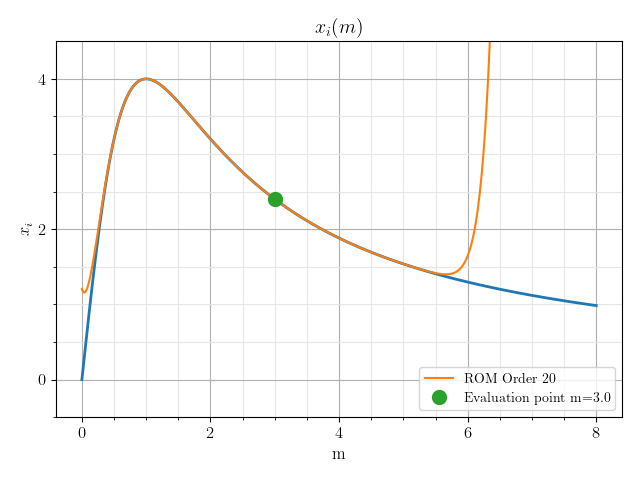

In [28]:
m_plot = np.linspace(0,m.real+5,500)
x_intanalyt, y_intanalyt = intersect_eval(r.real,m_plot,b.real)


plt.figure()

plt.title('$x_i(m)$')
plt.plot(m_plot,x_intanalyt,'-',c='C0',lw=2)

# Get the TSE behavior.
x_oti = X[0,0]
xnew_eval = np.zeros_like(m_plot)
ordi = 20
for i in range(m_plot.size):
    x_oti_eval = x_oti.truncate([[2,ordi+1]])
    xnew_eval[i] = x_oti_eval.rom_eval([1,2,3],[0,m_plot[i]-m.real,0]).real

plt.plot(m_plot,xnew_eval,'-',c='C1',ms=5,label='ROM Order '+str(ordi))

plt.plot(m.real,X[0,0].real,'o',c='C2',ms=10,label='Evaluation point m={0:.1f}'.format(m.real))

# plt.axis('equal')
plt.xlabel('m')
plt.ylabel('$x_i$')
ax = plt.gca()

plt.axis([
    None,None,
    min(x_intanalyt[~np.isnan(x_intanalyt)])-.5,
    max(x_intanalyt[~np.isnan(x_intanalyt)])+.5])
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
plt.grid()
plt.grid(which='minor', color=(0.9,0.9,0.9))
plt.legend(fontsize=10)
plt.tight_layout()


plt.show()



<IPython.core.display.Javascript object>


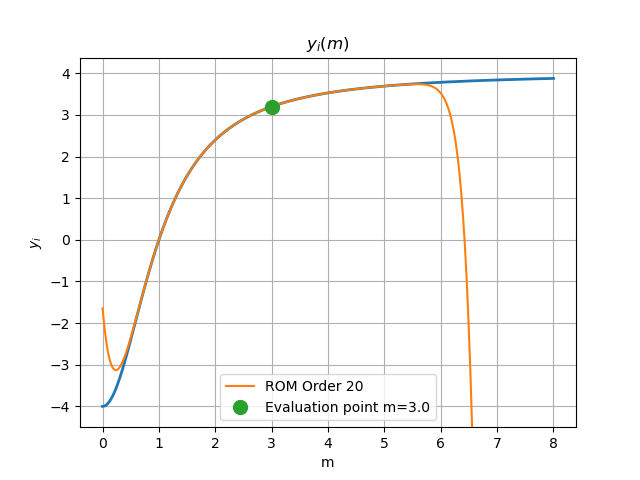

In [36]:
plt.figure()

plt.title('$y_i(m)$')
plt.plot(m_plot,y_intanalyt,'-',c='C0',lw=2)

# Get the TSE behavior.
y_oti = X[1,0]
ynew_eval = np.zeros_like(m_plot)
ordi = 20
for i in range(m_plot.size):
    y_oti_eval = y_oti.truncate([[2,ordi+1]])
    ynew_eval[i] = y_oti_eval.rom_eval([1,2,3],[0,m_plot[i]-m.real,0]).real

plt.plot(m_plot,ynew_eval,'-',c='C1',ms=5,label='ROM Order '+str(ordi))

plt.plot(m.real,X[1,0].real,'o',c='C2',ms=10,label='Evaluation point m={0:.1f}'.format(m.real))

# plt.axis('equal')
plt.xlabel('m')
plt.ylabel('$y_i$')
ax = plt.gca()

# ax.xaxis.set_major_locator(MultipleLocator(1))
# ax.yaxis.set_major_locator(MultipleLocator(1))


plt.grid()
plt.legend()

plt.axis([
    None,None,
    min(y_intanalyt[~np.isnan(y_intanalyt)])-.5,
    max(y_intanalyt[~np.isnan(y_intanalyt)])+.5])

plt.show()




In [37]:
deriv = [[2,1]]
print(x_int[0,0].get_deriv(deriv))
print(y_int[0,0].get_deriv(deriv))

-0.6399999999999999
0.48000000000000065


In [38]:
Xder = X.get_deriv(deriv)
print(Xder[0,0])
print(Xder[1,0])

-0.64
0.48


In [12]:
x_int[0,0].rom_eval([1,2,3],[Δr,Δm,Δb])

2.1025

In [13]:
X[0,0].rom_eval([1,2,3],[Δr,Δm,Δb])

2.1025

In [14]:
x0[0,0]

1.0000

In [17]:
fun2(X,r,m,b).real

array([[ 0.00000000e+00],
       [-3.33066907e-16]])

In [18]:
fun2(Xnew,rnew,mnew,bnew)

matso< shape: (2, 1), 
 - Column 0
(0,0) -0.120481
(1,0) 1.33227e-15
>

In [13]:
import sympy as sym

In [14]:
xs,ms,bs,rs = sym.symbols('x m b r')

In [15]:
ys = ms*xs+bs
ys

b + m*x

In [16]:
fs= xs**2+ys**2-rs**2
fs.expand()

b**2 + 2*b*m*x + m**2*x**2 - r**2 + x**2

In [17]:
xs_int,xs2_int =sym.solve(fs,xs)

In [18]:
xs_int

(-b*m + sqrt(-b**2 + m**2*r**2 + r**2))/(m**2 + 1)

In [19]:
xs2_int

-(b*m + sqrt(-b**2 + m**2*r**2 + r**2))/(m**2 + 1)

In [20]:
ys_int = ms*xs_int + bs

ys_int.expand().doit().factor()

(b + m*sqrt(-b**2 + m**2*r**2 + r**2))/(m**2 + 1)

In [21]:
ys2_int = ms*xs2_int + bs

ys2_int.expand().doit().factor()

(b - m*sqrt(-b**2 + m**2*r**2 + r**2))/(m**2 + 1)

In [19]:
d1xm = xs_int.diff(ms,1)
d1ym = ys_int.diff(ms,1)

d2xm = xs_int.diff(ms,2)
d2ym = ys_int.diff(ms,2)

d3xm = xs_int.diff(ms,3)
d3ym = ys_int.diff(ms,3)

d4xm = xs_int.diff(ms,4)
d4ym = ys_int.diff(ms,4)

d10xm = xs_int.diff(ms,10)
d10ym = ys_int.diff(ms,10)

d20xm = xs_int.diff(ms,20)
d20ym = ys_int.diff(ms,20)

In [20]:
d1xm.subs(dict(r=r.real,m=m.real,b=b.real)),d1ym.subs(dict(r=r.real,m=m.real,b=b.real))

(-0.684018778721877, 0.609838667696594)

In [21]:
d2xm.subs(dict(r=r.real,m=m.real,b=b.real)),d2ym.subs(dict(r=r.real,m=m.real,b=b.real))

(0.279263128725020, -0.530248171268695)

In [22]:
d4xm.subs(dict(r=r.real,m=m.real,b=b.real)),d4ym.subs(dict(r=r.real,m=m.real,b=b.real))

(-0.151332540409449, -0.783877351249161)

In [23]:
d10xm.subs(dict(r=r.real,m=m.real,b=b.real)),d10ym.subs(dict(r=r.real,m=m.real,b=b.real))


(-156.740454471425, 23.9830251804654)

In [24]:
d20xm.subs(dict(r=r.real,m=m.real,b=b.real)),d20ym.subs(dict(r=r.real,m=m.real,b=b.real))

(-2940933900.62463, -2389550442.93668)

In [19]:
X.get_deriv([[2,20]])

array([[-2.94093390e+09],
       [-2.38955044e+09]])

In [22]:
from sympy.utilities.lambdify import lambdify

In [23]:
intersect_eval = lambdify([rs,ms,bs],[xs_int,ys_int])

In [179]:
# 20th order derivatives w.r.t. 3 vars.
h = coti.get_dHelp()
h.get_ndir_total(3,20)

1771